In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 500)

spark = (
    SparkSession.builder.appName("Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '16g')
    .config('spark.executor.memory', '16g')
    .getOrCreate()
)


your 131072x1 screen size is bogus. expect trouble
24/10/08 21:34:12 WARN Utils: Your hostname, Andy-PC resolves to a loopback address: 127.0.1.1; using 172.28.56.83 instead (on interface eth0)
24/10/08 21:34:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 21:34:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
tbl_merchants = spark.read.parquet("../data/curated/tbl_merchants")
tbl_merchants = tbl_merchants.withColumn('tags', F.regexp_replace('tags', r'\(', r'\[')) \
    .withColumn('tags', F.lower(F.regexp_replace('tags', r'\)', r'\]')))


tbl_merchants = tbl_merchants.withColumn('tags1', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=1)))
tbl_merchants = tbl_merchants.withColumn('tags2', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=2)))
tbl_merchants = tbl_merchants.withColumn('tags3', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=3)).cast(DoubleType()))

tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants = tbl_merchants.withColumnRenamed('tags3', 'take_rate')
tbl_merchants = tbl_merchants.withColumnRenamed('tags2', 'type')
tbl_merchants = tbl_merchants.withColumnRenamed("name", "merchant_name")
tbl_merchants = tbl_merchants.drop('tags')
tbl_merchants = tbl_merchants.withColumnRenamed('tags1', 'tags')

tbl_merchants.show()

+--------------------+------------+--------------------+----+---------+
|       merchant_name|merchant_abn|                tags|type|take_rate|
+--------------------+------------+--------------------+----+---------+
|       Felis Limited| 10023283211|furniture, home f...|   e|     0.18|
|Arcu Ac Orci Corp...| 10142254217|cable, satellite,...|   b|     4.22|
|    Nunc Sed Company| 10165489824|jewelry, watch, c...|   b|      4.4|
|Ultricies Digniss...| 10187291046|watch, clock, jew...|   b|     3.29|
| Enim Condimentum PC| 10192359162|music, musical in...|   a|     6.33|
|       Fusce Company| 10206519221|gift, card, novel...|   a|     6.34|
|Aliquam Enim Inco...| 10255988167|computers, comput...|   b|     4.32|
|    Ipsum Primis Ltd| 10264435225|watch, clock, jew...|   c|     2.39|
|Pede Ultrices Ind...| 10279061213|computer programm...|   a|     5.71|
|           Nunc Inc.| 10323485998|furniture, home f...|   a|     6.61|
|Facilisis Facilis...| 10342410215|computers, comput...|   a|   

In [3]:
tbl_merchants = tbl_merchants.toPandas()

In [4]:
df = pd.read_csv('../data/curated/predictions.csv') #this is from alan

df = df.sort_values(by='expected_revenue_predicted_sum', ascending=False)
df = df.merge(tbl_merchants, on='merchant_abn', how='left')

top_10_merchants = df.head(10)
top_10_merchants = top_10_merchants.set_index('merchant_abn')
columns_to_keep = [col for col in top_10_merchants.columns if '|' not in col]
top_10_merchants = top_10_merchants[columns_to_keep]

top_100_merchants = df.head(100)
top_100_merchants = top_100_merchants.set_index('merchant_abn')
columns_to_keep = [col for col in top_100_merchants.columns if '|' not in col]
top_100_merchants = top_100_merchants[columns_to_keep]


top_100_merchants.to_csv("cleaned_top_100.csv")

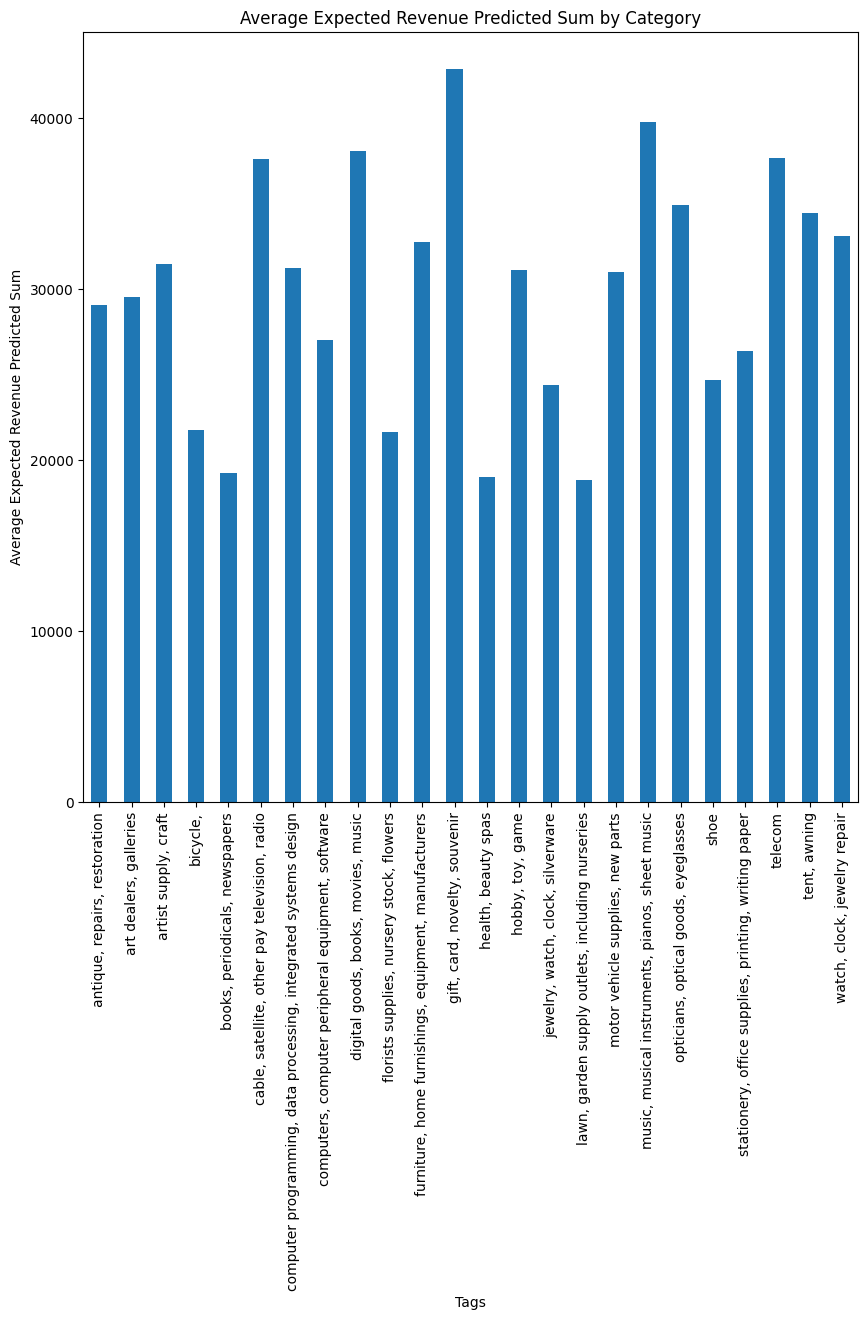

In [5]:
category_performance = top_100_merchants.groupby('tags').agg({
    'expected_revenue_predicted_sum': 'mean'
})

plt.figure(figsize=(10, 10))
category_performance['expected_revenue_predicted_sum'].plot(kind='bar')

plt.title('Average Expected Revenue Predicted Sum by Category')
plt.xlabel('Tags')
plt.ylabel('Average Expected Revenue Predicted Sum')
plt.show()


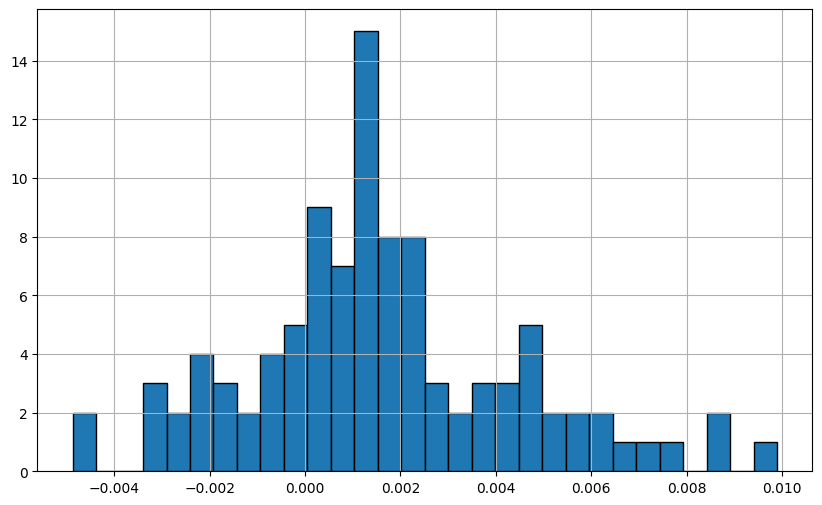

In [6]:
top_100_merchants['sales_difference'] = top_100_merchants['total_seasonal_sales'] - top_100_merchants['total_original_sales']
top_seasonal_merchants = top_100_merchants[[ 'sales_difference']].sort_values(by='sales_difference', ascending=False)
plt.figure(figsize=(10, 6))
plt.hist(top_seasonal_merchants['sales_difference'], bins=30, edgecolor='black')

plt.grid(True)
plt.show()

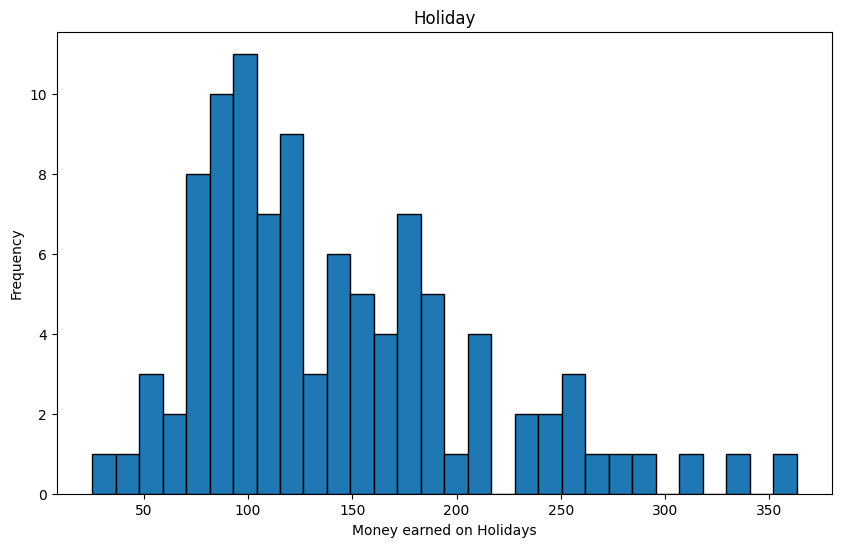

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(top_100_merchants['is_holiday'], bins=30, edgecolor='black')
plt.title('Holiday')
plt.xlabel('Money earned on Holidays')
plt.ylabel('Frequency')
plt.show()

tags
tent, awning                                                        12
lawn, garden supply outlets, including nurseries                     8
motor vehicle supplies, new parts                                    8
computers, computer peripheral equipment, software                   6
artist supply, craft                                                 6
gift, card, novelty, souvenir                                        6
computer programming, data processing, integrated systems design     5
florists supplies, nursery stock, flowers                            5
watch, clock, jewelry repair                                         5
furniture, home furnishings, equipment, manufacturers                5
music, musical instruments, pianos, sheet music                      4
stationery, office supplies, printing, writing paper                 4
books, periodicals, newspapers                                       3
opticians, optical goods, eyeglasses                                 3
s

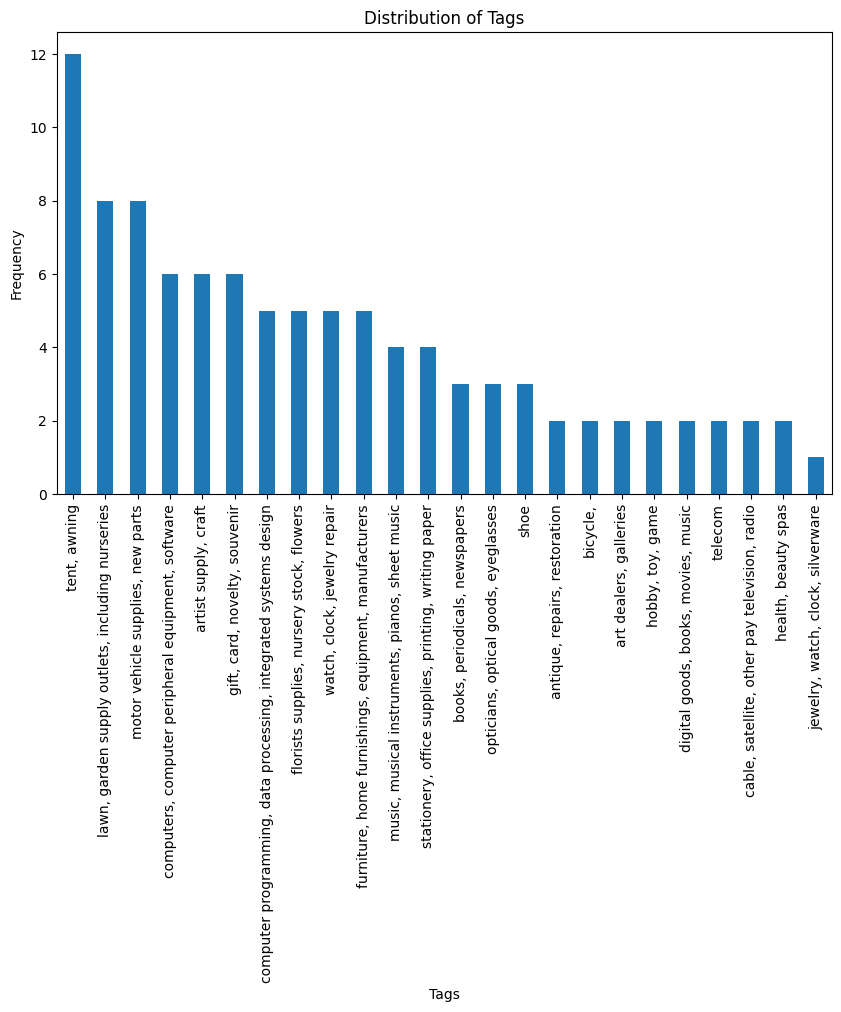

In [8]:
tag_counts = top_100_merchants['tags'].value_counts()
print(tag_counts)

plt.figure(figsize=(10, 6))
tag_counts.plot(kind='bar')
plt.title('Distribution of Tags')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.show()

In [9]:
#top_100_merchants['top_100'] = 1
df["top_100"] = 0
df["top_10"] = 0
columns_to_keep = [col for col in df.columns if '|' not in col]
df = df[columns_to_keep]

df.loc[df["merchant_abn"].isin(top_100_merchants.index), "top_100"] = 1
df.loc[df["merchant_abn"].isin(top_10_merchants.index), "top_10"] = 1   
X = df.drop(['top_100','Unnamed: 0','merchant_name','tags','type'], axis = 1)
y = df['top_100']

model = RandomForestClassifier()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

expected_revenue_predicted_sum                    0.232889
moving_average_expected_revenue_predicted_sum     0.211291
is_holiday                                        0.181427
total_seasonal_sales                              0.129129
month                                             0.050631
day_of_year                                       0.043023
day_of_month                                      0.036246
total_original_sales                              0.030159
mean_merchant_fraud_probability                   0.015480
median_household_income                           0.013262
num_sales_predicted_sum                           0.012831
moving_average_num_sales_predicted_sum            0.009746
median_age                                        0.007092
moving_average_mean_dollar_value                  0.006185
mean_fraud_probability                            0.005992
moving_average_mean_dollar_value_predicted_sum    0.003169
mean_household_size                               0.0029

Bunch of clustering algorithms, basically saying that there wasn't much difference between the top 100 and non top 100. Take into account that im including basically all the features, maybe taking out some might help but not sure.

In [10]:
kmeans = KMeans(n_clusters=2) 

features = df.drop(columns=['top_100', 'Unnamed: 0', 'merchant_name', 'tags', 'type', 'top_10'])

X = features
df['cluster'] = kmeans.fit_predict(X)

cluster_comparison = pd.crosstab(df['top_100'], df['cluster'])
print(cluster_comparison)

cluster     0     1
top_100            
0        1975  1951
1          46    54


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=0.8, min_samples=3)
df['cluster'] = dbscan.fit_predict(X_scaled)

cluster_comparison = pd.crosstab(df['top_100'], df['cluster'])
print(cluster_comparison)


cluster    -1   0     1   2   3   4   5   6   7   8
top_100                                            
0        1965   3  1932   5   3   5   3   3   4   3
1         100   0     0   0   0   0   0   0   0   0


In [12]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=2,  linkage='ward')
df['cluster'] = agglomerative_clustering.fit_predict(X)

cluster_comparison = pd.crosstab(df['top_100'], df['cluster'])
print(cluster_comparison)


cluster     0     1
top_100            
0        1976  1950
1          54    46


In [13]:
mean_shift = MeanShift()
df['cluster'] = mean_shift.fit_predict(X)

cluster_comparison = pd.crosstab(df['top_100'], df['cluster'])
print(cluster_comparison)


cluster     0     1    2
top_100                 
0        1469  1505  952
1          33    44   23


In [14]:
gmm = GaussianMixture(n_components=2)
df['cluster'] = gmm.fit_predict(X)

cluster_comparison = pd.crosstab(df['top_100'], df['cluster'])
print(cluster_comparison)


cluster     0     1
top_100            
0        1582  2344
1         100     0


GMM is weird, ran this multiple times, it either gets its wrong 100% time of 100% time correct. Think its algorithm not suited for us.

In [17]:
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=8)
df['cluster'] = spectral.fit_predict(X)

cluster_comparison = pd.crosstab(df['top_100'], df['cluster'])
print(cluster_comparison)

/home/ache8119/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


cluster     0    1
top_100           
0        3750  176
1          95    5


In [18]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

score = silhouette_score(X, df['cluster'])
print(f'Silhouette Score: {score}')
ari_score = adjusted_rand_score(df['top_100'], df['cluster'])
print(f'Adjusted Rand Index (ARI): {ari_score}')


Silhouette Score: 0.15742554578562087
Adjusted Rand Index (ARI): 0.0034234172517248924
